In [ ]:
## This is a series of examples demonstrating the use of the icanswim/cosmosis repo 
## for data science and machine learning projects.
## This repo is intended to be used as the boiler plate for data science and machine learning projects.
## See the icanswim/qchem repo for a demonstration of the use of this (icanswim/cosmosis) repo.

In [1]:
from model import FFNet, tv_model, IdentityModel, GPT
from learning import Learn, Selector, Metrics
from dataset import CDataset, SKDS, TVDS, ExampleDataset
from dataset import ImageDatasetStats, AsTensor, SqueezeN, DType, Pad1d, EmbedLookup, Reshape

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [3]:
#example cosmosis dataset (CDataset)
import numpy as np

class ExampleDataset(CDataset):
    #zero is the lookup for the padding index
    embed_lookup = {'feature_4': {'a': 1,'b': 2,'c': 3,'d': 4, '0': 0},
                    'feature_3': {'z1': 1, 'y1': 2, 'x1': 3, '0': 0},
                    'feature_6': {'e': 1, 'f': 2, 'g': 3, '0': 0}}
    
    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([[.02,.03],[.04,.05]]),
                       'feature_3': np.asarray(['z1']),
                       'feature_4': np.asarray(['c','c','d']),
                       'feature_5': np.asarray([1.1]),
                       'feature_6': np.asarray(['e','f','g'])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([[.1,.2],[.3,.4]]),
                       'feature_3': np.asarray(['x1','z1','y1']),
                       'feature_4': np.asarray(['d','a','d']),
                       'feature_5': np.asarray([1.2]),
                       'feature_6': np.asarray(['f','f','g'])}}
        
        print(boom)
        return datadic
    
class ExampleTransform():
    def __init__(self, num):
        self.num = num
        
    def __call__(self, arr):
        return np.add(arr, self.num)

#'embed_params': {'embed': [('feature_3',4,16,0,True,False),('feature_4',5,16,0,True,False)]}
# ds_params = {dataset_manager_keys: {dataset_keys: {learner_keys: {module_keys: dataset_keys))))
# ds_params = {'train_params': {'input_dict': {'model_input' {'X': ['feature_1','feature_5']}}}}

lookup_feature_3 = ExampleDataset.embed_lookup['feature_3']
lookup_feature_4 = ExampleDataset.embed_lookup['feature_4']
lookup_feature_6 = ExampleDataset.embed_lookup['feature_6']
ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['feature_1','feature_2']},
                                             'embedding_input': {'feature_3': ['feature_3'],
                                                                 'feature_4': ['feature_4']},
                                             'criterion_input': {'target': ['feature_5']}},
                              'transforms': {'feature_1': [ExampleTransform(10), AsTensor()],
                                             'feature_2': [Reshape(-1), AsTensor()],
                                             'feature_3': [Pad1d(5), EmbedLookup(lookup_feature_3), AsTensor()],
                                             'feature_4': [Pad1d(5), EmbedLookup(lookup_feature_4), AsTensor()],
                                             'feature_5': [AsTensor()],
                                             'feature_6': [EmbedLookup(lookup_feature_6), AsTensor()]},
                              'boom': 'bang'}}
    
d = ExampleDataset(**ds_params['train_params'])
d[1]

bang
CDataset created...


{'model_input': {'X': tensor([10.0400,  0.0200,  0.0300,  0.0400,  0.0500], dtype=torch.float64)},
 'embedding_input': {'feature_3': tensor([1, 0, 0, 0, 0]),
  'feature_4': tensor([3, 3, 4, 0, 0])},
 'criterion_input': {'target': tensor([1.1000], dtype=torch.float64)}}

In [4]:
model_params = {'device': 'cpu',
                'embed_params': {'embed': [('feature_3',4,8,0,False,True),('feature_4',5,8,0,False,True)]}}
m = IdentityModel(model_params)
print(m)
print(m.embeddings)

CModel loaded...
IdentityModel(
  (layers): ModuleList(
    (0): Identity()
  )
)
{'feature_3': Embedding(4, 8, padding_idx=0), 'feature_4': Embedding(5, 8, padding_idx=0)}


In [5]:
y = m(d[1])
print(y)
print(y.shape)

tensor([10.0400,  0.0200,  0.0300,  0.0400,  0.0500,  1.4438,  0.8489, -2.0399,
         0.3103, -1.6343, -1.0394, -1.1311, -1.3200,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5967, -1.0174, -1.7063,
        -1.3047, -0.2403, -0.0388,  0.1125, -0.0921,  0.5967, -1.0174, -1.7063,
        -1.3047, -0.2403, -0.0388,  0.1125, -0.0921,  2.4853,  0.2394, -0.2421,
        -0.3170,  0.9553, -1.7881, -1.7781, -0.0765,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], dtype=torch.float64)
torch.Size([85])


In [7]:
#example cosmosis dataset (CDataset)

#'embed_params': {'embed': [('feature_3',4,16,0,True),('feature_4',5,16,0,True)],
#                 'embed2': [('feature_6',4,8,0,True)],
#                 'flatten_embed': True}


lookup_feature_3 = ExampleDataset.embed_lookup['feature_3']
lookup_feature_4 = ExampleDataset.embed_lookup['feature_4']
lookup_feature_6 = ExampleDataset.embed_lookup['feature_6']
ds_params = {'train_params': {'input_dict': {'model_input': {},
                                             'embedding_input': {'feature_3': ['feature_3']},
                                             'criterion_input': {'target': ['feature_5']}},
                              'transforms': {'feature_3': [Pad1d(12), EmbedLookup(lookup_feature_3), AsTensor()],
                                             'feature_5': [AsTensor()]},
                              'boom': 'bang'}}
    
ed = ExampleDataset(**ds_params['train_params'])
ed[1]

model_params = {'device': 'cpu',
                'd_model': 16, # matches embedding dimension
                'nhead': 4, 
                'num_layers': 2,
                'dim_feedforward': 128,
                'embed_params': {'embed': [('feature_3',4,16,0,True,False)]}} # matches d_model dimension
                                 

gpt = GPT(model_params)
print(gpt)
print(gpt.embeddings)
y = gpt(ed[1])
print(y)
print(y.shape)


bang
CDataset created...
CModel loaded...
GPT(
  (layers): ModuleList(
    (0): TransformerDecoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=F

In [6]:
#example cosmosis sklearn regression dataset wrapper (SKDS)
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

creating scikit learn make_regression dataset...
CDataset created...


{'model_input': {'features': array([-0.18283719, -1.9093667 , -0.403545  ,  0.4101531 ,  0.4615606 ],
        dtype=float32)},
 'criterion_input': {'target': array([-40.253674], dtype=float32)}}

In [6]:
#example cosmosis sklearn classification dataset wrapper (SKDS)
ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'transforms': {'y': [],
                                             'X': [AsTensor()]},
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 1000,
                                            'n_features': 30,
                                            'n_informative': 20,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]['criterion_input']['target']

creating scikit learn make_classification dataset...
CDataset created...


array([2])

In [5]:
#example cosmosis torchvision image dataset wrapper (TVDS)
ds_params={'dataset': 'MNIST',
           'input_dict': {'model_input': {'features': ['images'],},
                          'criterion_input': {'target': ['labels']}},
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

creating torch vision MNIST dataset...
CDataset created...


{'model_input': {'image': <PIL.Image.Image image mode=L size=224x224>},
 'criterion_input': {'target': 0}}

In [6]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and PIL stats
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

creating torch vision MNIST dataset...
CDataset created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


creating scikit learn make_regression dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:01.056730
epoch: 0, lr: 0.01
train loss: 545636.6221064815, val loss: 387520.0028409091
learning time: 0:00:06.860692
epoch: 10, lr: 0.01
train loss: 9957.25109411169, val loss: 6740.813432173295
learning time: 0:00:11.418071
epoch: 18, lr: 0.0025
train loss: 9898.928833007812, val loss: 7151.990900213068
early stopping!  learning rate is below the set minimum...
test loss: 9821.76571377841
learning time: 0:00:11.603111


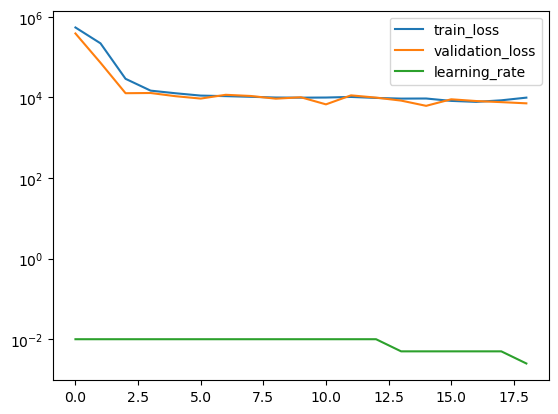

In [3]:
#example cosmosis sklearn regression dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples':20000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'min_lr': .005} #break if learning rate falls below                        
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5, 
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=40, gpu=True)

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:04.064586
epoch: 0, lr: 0.01
train loss: 0.010652886867359445, val loss: 0.010471147739798086
sklearn train metric: 0.5708200360849429, sklearn validation metric: 0.6093094567383296
learning time: 0:00:24.740527
epoch: 5, lr: 0.01
train loss: 0.009521036333789973, val loss: 0.009638075366552569
sklearn train metric: 0.7342490293831634, sklearn validation metric: 0.7241203623471957
learning time: 0:00:43.578432
epoch: 10, lr: 0.01
train loss: 0.008651175411697819, val loss: 0.008907659504658137
sklearn train metric: 0.8169910867188441, sklearn validation metric: 0.7925809450802559
learning time: 0:01:04.487510
epoch: 15, lr: 0.01
train loss: 0.008278318971647939, val loss: 0.008576344742447648
sklearn train metric: 0.8480534789222101, sklearn validation metric: 0.8209933567484783
test loss: 0.008440470223466301
learning time: 0:01:20

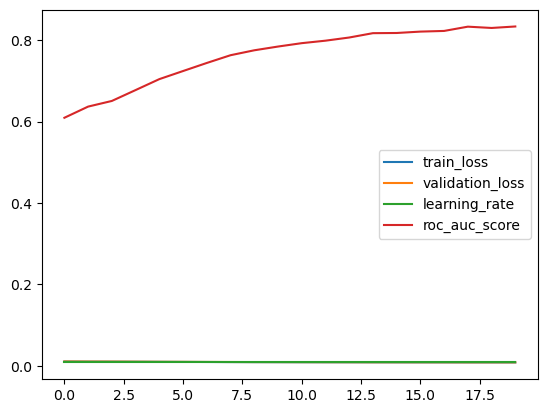

In [8]:
#example cosmosis sklearn classification dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4,
                'softmax': 'softmax',
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'transforms': {'y': [SqueezeN()],
                                             'X': []},
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 100000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_redundant': 5,
                                            'n_repeated': 5,
                                            'n_clusters_per_class': 5,
                                            'flip_y': 0.05,
                                            'class_sep': 0.05,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 20,
                  'log_plot': False,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=(300,256,.2), 
          squeeze_y_pred=False, batch_size=128, epochs=20, 
          save_model='demo_model')

In [9]:
#example inference with cosmosis sklearn classification dataset wrapper (SKDS) and custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     

metrics_params = {}
opt_params = {}
sample_params = {}
sched_params = {}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=None,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=128, epochs=1, load_model='demo_model.pth')

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
model loaded from pickle...
running model on gpu...
inference 2024-01-30 09:59:18.959869 complete and saved to csv...


creating torch vision CIFAR10 dataset...


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data/
CDataset created...
creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
torchvision model resnet18 loaded...
running model on gpu...
learning time: 0:00:04.738559
epoch: 0, lr: 0.01
train loss: 2.311521966934204, val loss: 1.9930767320817517
sklearn train metric: 0.6471858728271811, sklearn validation metric: 0.7425938382662041
learning time: 0:00:17.059567
epoch: 3, lr: 0.01
train loss: 1.702039137840271, val loss: 1.710098672297693
sklearn train metric: 0.8221158152875127, sklearn validation metric: 0.8298716193539803
learning time: 0:00:29.831797
epoch: 6, lr: 0.01
train loss: 1.4666910207271575, val loss: 1.4823509983478054
sklearn train metric: 0.8692649425362153, sklearn validation metric: 0.8689450360899584
learning time: 0:00:42.616418
epoch: 9, lr: 0.01
train loss: 1.278647863149643, val loss: 1.427007910705382
sklearn train metric: 0.90150134955471, sklearn validation metric: 0.

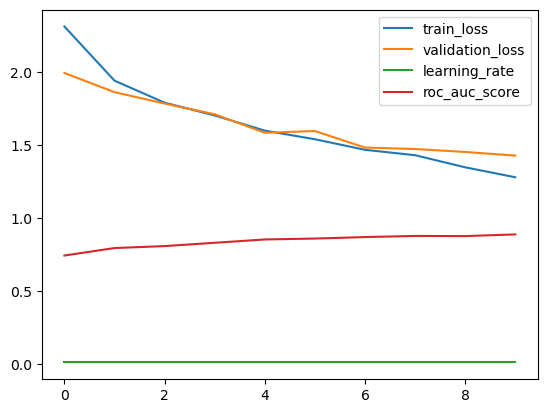

In [10]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params, 
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=16, epochs=10)

creating torch vision CIFAR10 dataset...
CDataset created...
creating torch vision CIFAR10 dataset...
CDataset created...
torchvision model resnext50_32x4d loaded...
running model on gpu...
learning time: 0:00:56.040228
epoch: 0, lr: 0.01
train loss: 2.633864553928375, val loss: 2.1059755163808025
sklearn train metric: 0.5545010105221794, sklearn validation metric: 0.6861537506554425
learning time: 0:01:51.703332
epoch: 1, lr: 0.01
train loss: 2.0997875771522523, val loss: 2.0373207599886003
sklearn train metric: 0.686515385134714, sklearn validation metric: 0.7292397250301292
learning time: 0:02:47.610665
epoch: 2, lr: 0.01
train loss: 1.9969928140640258, val loss: 1.893813217839887
sklearn train metric: 0.732374651691321, sklearn validation metric: 0.7725967229657129
learning time: 0:03:43.715679
epoch: 3, lr: 0.01
train loss: 1.9165824122428894, val loss: 1.8645907525093324
sklearn train metric: 0.7587980764476405, sklearn validation metric: 0.7886757057433087
learning time: 0:04:40

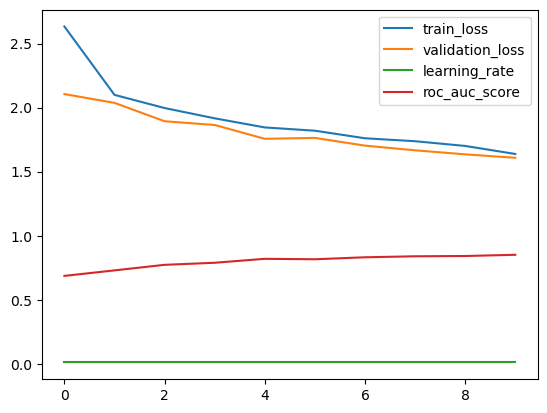

In [2]:
#example cosmosis torchvision dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 30, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=16, epochs=10)